## RandAugmentation_simple
- baseline code가 존재하는 디렉토리에 해당 노트북을 다운받아 실행해주시기바랍니다.

In [ ]:
import torch
import os
import sys
import yaml
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from typing import Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

if "./" not in sys.path:
    sys.path.append("./")

In [ ]:
from src.model import Model
from src.trainer import TorchTrainer
from src.loss import CustomCriterion

In [ ]:
MEAN_V = (0.4914, 0.4822, 0.4465)
STD_V = (0.2470, 0.2435, 0.2616)

DATASET_DIR = "./input/cifar10"

In [ ]:
def generate_transform(resize: int = 32, aug_fcns: Tuple = ()) -> transforms.transforms.Compose:
    """Generate train augmentation policy."""
    transform_fcns = []
    transform_fcns.append(transforms.Resize((resize, resize)))
    transform_fcns += list(aug_fcns)
    
    transform_fcns.append(transforms.ToTensor())
    transform_fcns.append(transforms.Normalize(MEAN_V, STD_V))
    
    return transforms.Compose(transform_fcns)
    

In [ ]:
def load_cifar10(img_size: int = 32, 
                 aug_fcns: Tuple = (), 
                 validation_ratio: float = 0.8,
                ) -> Tuple[CIFAR10, CIFAR10, CIFAR10]:
    tf_train = generate_transform(resize=img_size, aug_fcns=aug_fcns)
    tf_test = generate_transform(resize=img_size)
    
    train_dataset = CIFAR10(root=DATASET_DIR, train=True, download=True, transform=tf_train)
    train_length = int(len(train_dataset) * validation_ratio)
    val_length = len(train_dataset) - train_length

    train_dataset, val_dataset = random_split(train_dataset, [train_length, val_length])
    test_dataset = CIFAR10(root=DATASET_DIR, train=False, download=True, transform=tf_test)
    
    return train_dataset, val_dataset, test_dataset
    

In [ ]:
def tensor_to_img(tensor_img: torch.Tensor) -> np.ndarray:
    return ((tensor_img.permute(1, 2, 0).numpy() * STD_V + MEAN_V) * 255).astype(np.uint8)

def visualize_datasets(_train_dataset: CIFAR10, _val_dataset: CIFAR10, _test_dataset: CIFAR10, title_prefix: str = "") -> None:
    fig, ax = plt.subplots(3, 7, figsize=(20, 10))

    for i in range(7):
        idx = np.random.randint(0, len(_val_dataset))

        ax[0][i].imshow(tensor_to_img(_train_dataset[idx][0]))
        ax[1][i].imshow(tensor_to_img(_val_dataset[idx][0]))
        ax[2][i].imshow(tensor_to_img(_test_dataset[idx][0]))

        ax[0][i].axis('off')
        ax[1][i].axis('off')
        ax[2][i].axis('off')

    fig.suptitle(f"{title_prefix} Visualization of Augmentation.\n(Each row represents train, validation, test dataset accordingly)")
    fig.show()

In [ ]:
import optuna
import yaml

In [ ]:
EPOCHS = 10
BATCH_SIZE = 256
    
def objective(trial: optuna.Trial) -> float:
    img_size = 32

    augmentation_functions = []
    use_color_jitter = trial.suggest_categorical("aug_color_jitter", [True, False])
    use_random_perspective = trial.suggest_categorical("aug_random_perspective", [True, False])
    use_random_flip = trial.suggest_categorical("aug_random_flip", [True, False])
    
    if use_color_jitter:
        augmentation_functions.append(transforms.ColorJitter(brightness=(0.5, 1.5), 
                                                             contrast=(0.5, 1.5), 
                                                             saturation=(0.5, 1.5)))
    if use_random_perspective:
        augmentation_functions.append(transforms.RandomPerspective())
    
    if use_random_flip:
        augmentation_functions.append(transforms.RandomHorizontalFlip())
    
        
    train_dataset, val_dataset, test_dataset = load_cifar10(img_size=img_size, 
                                                            aug_fcns = tuple(augmentation_functions), 
                                                            validation_ratio=0.8)
    
    visualize_datasets(train_dataset, val_dataset, test_dataset, title_prefix=f"Trial {trial.number:03d} //")
    plt.draw()
    plt.show()
    print(augmentation_functions)
    
    with open("./configs/model/mobilenetv3.yaml", "r") as f:
        model_cfg = yaml.load(f, yaml.SafeLoader)

    model_cfg['backbone'][-1][-1] = [10]

    model = Model(model_cfg, verbose=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    optimizer = torch.optim.SGD(model.model.parameters(), lr=0.1, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=0.1, steps_per_epoch=len(train_dataset), epochs=EPOCHS, pct_start=0.05)
    criterion = CustomCriterion(samples_per_cls=None, device=device)

    train_loader = DataLoader(dataset=train_dataset, 
                              pin_memory=torch.cuda.is_available(), 
                              shuffle=True, 
                              batch_size=BATCH_SIZE, 
                              num_workers=4, 
                              drop_last=True)
    val_loader = DataLoader(dataset=val_dataset, 
                            pin_memory=torch.cuda.is_available(), 
                            shuffle=False, 
                            batch_size=BATCH_SIZE, 
                            num_workers=4)
    test_loader = DataLoader(dataset=test_dataset, 
                             pin_memory=torch.cuda.is_available(), 
                             shuffle=False, 
                             batch_size=BATCH_SIZE, 
                             num_workers=4)

    exp_dir = "./exp/autoaug"
    os.makedirs(exp_dir, exist_ok=True)
    trainer = TorchTrainer(model=model, 
                           criterion=criterion, 
                           optimizer=optimizer, 
                           scheduler=scheduler, 
                           device=device, 
                           verbose=1, 
                           model_path=os.path.join(exp_dir, "best.pt"))

    best_acc, best_f1 = trainer.train(train_dataloader=train_loader, 
                                      n_epoch=EPOCHS, 
                                      val_dataloader=val_loader)
    print("TEST DATASET")
    test_loss, test_f1, test_accuracy = trainer.test(model, test_loader)
    
    return test_f1

[I 2021-05-22 20:23:37,094] A new study created in memory with name: autoaug


Files already downloaded and verified
Files already downloaded and verified


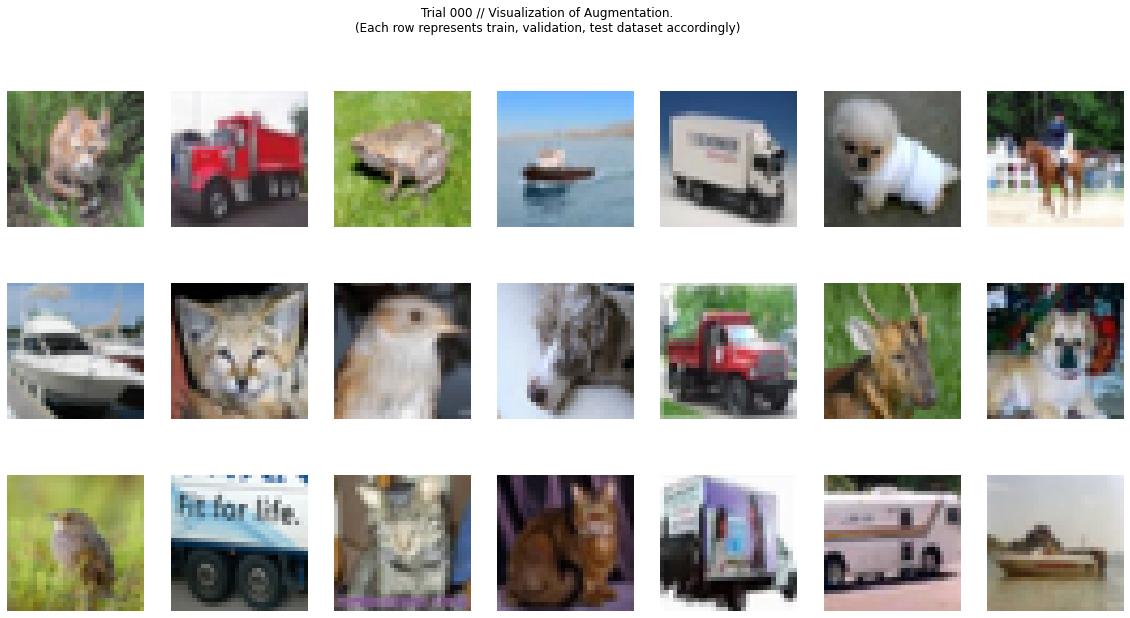

[]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |     34,760 | InvertedResid

Train: [001] Loss: 1.920, Acc: 28.60% F1(macro): 0.28: 100%|██████████| 156/156 [00:13<00:00, 11.44it/s]
 Val:       Loss: 1.616, Acc: 40.00% F1(macro): 0.38: 100%|██████████| 40/40 [00:01<00:00, 24.80it/s]


Model saved. Current best test f1: 0.384


Train: [002] Loss: 1.488, Acc: 45.78% F1(macro): 0.45: 100%|██████████| 156/156 [00:13<00:00, 11.26it/s]
 Val:       Loss: 1.390, Acc: 49.93% F1(macro): 0.49: 100%|██████████| 40/40 [00:01<00:00, 26.28it/s]


Model saved. Current best test f1: 0.493


Train: [003] Loss: 1.313, Acc: 52.87% F1(macro): 0.53: 100%|██████████| 156/156 [00:13<00:00, 11.27it/s]
 Val:       Loss: 1.313, Acc: 52.56% F1(macro): 0.52: 100%|██████████| 40/40 [00:01<00:00, 25.69it/s]


Model saved. Current best test f1: 0.517


Train: [004] Loss: 1.209, Acc: 56.64% F1(macro): 0.56: 100%|██████████| 156/156 [00:13<00:00, 11.36it/s]
 Val:       Loss: 1.270, Acc: 55.09% F1(macro): 0.55: 100%|██████████| 40/40 [00:01<00:00, 24.83it/s]


Model saved. Current best test f1: 0.550


Train: [005] Loss: 1.101, Acc: 60.49% F1(macro): 0.60: 100%|██████████| 156/156 [00:13<00:00, 11.58it/s]
 Val:       Loss: 1.218, Acc: 56.28% F1(macro): 0.56: 100%|██████████| 40/40 [00:01<00:00, 25.56it/s]


Model saved. Current best test f1: 0.559


Train: [006] Loss: 1.029, Acc: 63.36% F1(macro): 0.63: 100%|██████████| 156/156 [00:13<00:00, 11.25it/s]
 Val:       Loss: 1.178, Acc: 58.20% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 25.63it/s]


Model saved. Current best test f1: 0.579


Train: [007] Loss: 0.953, Acc: 66.21% F1(macro): 0.66: 100%|██████████| 156/156 [00:13<00:00, 11.41it/s]
 Val:       Loss: 1.155, Acc: 59.09% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 25.23it/s]


Model saved. Current best test f1: 0.584


Train: [008] Loss: 0.894, Acc: 68.21% F1(macro): 0.68: 100%|██████████| 156/156 [00:13<00:00, 11.40it/s]
 Val:       Loss: 1.183, Acc: 58.86% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 25.59it/s]


Model saved. Current best test f1: 0.585


Train: [009] Loss: 0.855, Acc: 69.43% F1(macro): 0.69: 100%|██████████| 156/156 [00:13<00:00, 11.47it/s]
 Val:       Loss: 1.179, Acc: 59.76% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 25.81it/s]


Model saved. Current best test f1: 0.595


Train: [010] Loss: 0.809, Acc: 71.51% F1(macro): 0.71: 100%|██████████| 156/156 [00:13<00:00, 11.28it/s]
 Val:       Loss: 1.169, Acc: 60.61% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 25.43it/s]


Model saved. Current best test f1: 0.604
TEST DATASET


 Val:       Loss: 1.186, Acc: 59.69% F1(macro): 0.59: 100%|██████████| 40/40 [00:01<00:00, 25.29it/s]
[I 2021-05-22 20:26:19,585] Trial 0 finished with value: 0.5937657993819225 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': False, 'aug_random_flip': False}. Best is trial 0 with value: 0.5937657993819225.


Files already downloaded and verified
Files already downloaded and verified


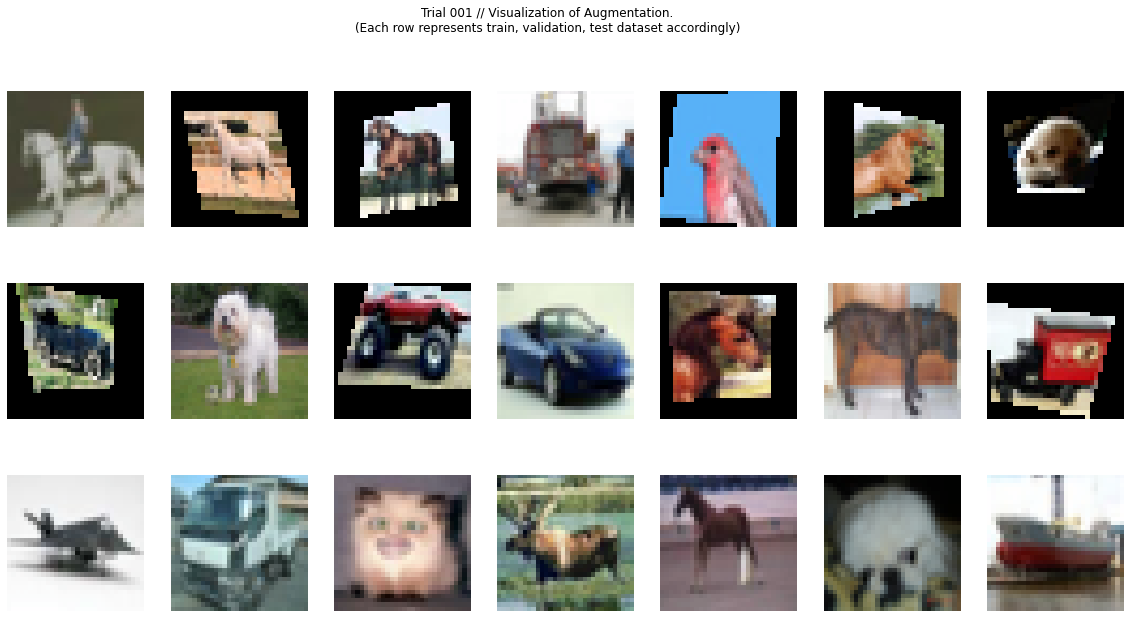

[RandomPerspective(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |   

Train: [001] Loss: 2.041, Acc: 23.98% F1(macro): 0.23: 100%|██████████| 156/156 [00:13<00:00, 11.24it/s]
 Val:       Loss: 1.923, Acc: 31.88% F1(macro): 0.31: 100%|██████████| 40/40 [00:01<00:00, 23.25it/s]


Model saved. Current best test f1: 0.310


Train: [002] Loss: 1.688, Acc: 37.30% F1(macro): 0.37: 100%|██████████| 156/156 [00:13<00:00, 11.27it/s]
 Val:       Loss: 1.662, Acc: 39.82% F1(macro): 0.39: 100%|██████████| 40/40 [00:01<00:00, 23.35it/s]


Model saved. Current best test f1: 0.387


Train: [003] Loss: 1.563, Acc: 43.10% F1(macro): 0.43: 100%|██████████| 156/156 [00:13<00:00, 11.18it/s]
 Val:       Loss: 1.586, Acc: 44.49% F1(macro): 0.44: 100%|██████████| 40/40 [00:01<00:00, 24.93it/s]


Model saved. Current best test f1: 0.439


Train: [004] Loss: 1.476, Acc: 46.28% F1(macro): 0.46: 100%|██████████| 156/156 [00:13<00:00, 11.41it/s]
 Val:       Loss: 1.468, Acc: 46.94% F1(macro): 0.46: 100%|██████████| 40/40 [00:01<00:00, 25.35it/s]


Model saved. Current best test f1: 0.465


Train: [005] Loss: 1.399, Acc: 49.39% F1(macro): 0.49: 100%|██████████| 156/156 [00:13<00:00, 11.31it/s]
 Val:       Loss: 1.441, Acc: 49.67% F1(macro): 0.49: 100%|██████████| 40/40 [00:01<00:00, 24.07it/s]


Model saved. Current best test f1: 0.491


Train: [006] Loss: 1.345, Acc: 51.16% F1(macro): 0.51: 100%|██████████| 156/156 [00:13<00:00, 11.32it/s]
 Val:       Loss: 1.361, Acc: 51.13% F1(macro): 0.51: 100%|██████████| 40/40 [00:01<00:00, 24.39it/s]


Model saved. Current best test f1: 0.507


Train: [007] Loss: 1.280, Acc: 53.81% F1(macro): 0.54: 100%|██████████| 156/156 [00:13<00:00, 11.32it/s]
 Val:       Loss: 1.340, Acc: 52.52% F1(macro): 0.53: 100%|██████████| 40/40 [00:01<00:00, 24.75it/s]


Model saved. Current best test f1: 0.527


Train: [008] Loss: 1.247, Acc: 55.16% F1(macro): 0.55: 100%|██████████| 156/156 [00:13<00:00, 11.37it/s]
 Val:       Loss: 1.278, Acc: 54.30% F1(macro): 0.54: 100%|██████████| 40/40 [00:01<00:00, 24.96it/s]


Model saved. Current best test f1: 0.537


Train: [009] Loss: 1.207, Acc: 56.59% F1(macro): 0.56: 100%|██████████| 156/156 [00:13<00:00, 11.22it/s]
 Val:       Loss: 1.279, Acc: 54.41% F1(macro): 0.54: 100%|██████████| 40/40 [00:01<00:00, 24.15it/s]


Model saved. Current best test f1: 0.543


Train: [010] Loss: 1.161, Acc: 58.26% F1(macro): 0.58: 100%|██████████| 156/156 [00:13<00:00, 11.28it/s]
 Val:       Loss: 1.239, Acc: 56.36% F1(macro): 0.56: 100%|██████████| 40/40 [00:01<00:00, 24.44it/s]


Model saved. Current best test f1: 0.564
TEST DATASET


 Val:       Loss: 1.114, Acc: 59.95% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 25.70it/s]
[I 2021-05-22 20:29:04,101] Trial 1 finished with value: 0.6009577855552984 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': True, 'aug_random_flip': False}. Best is trial 1 with value: 0.6009577855552984.


Files already downloaded and verified
Files already downloaded and verified


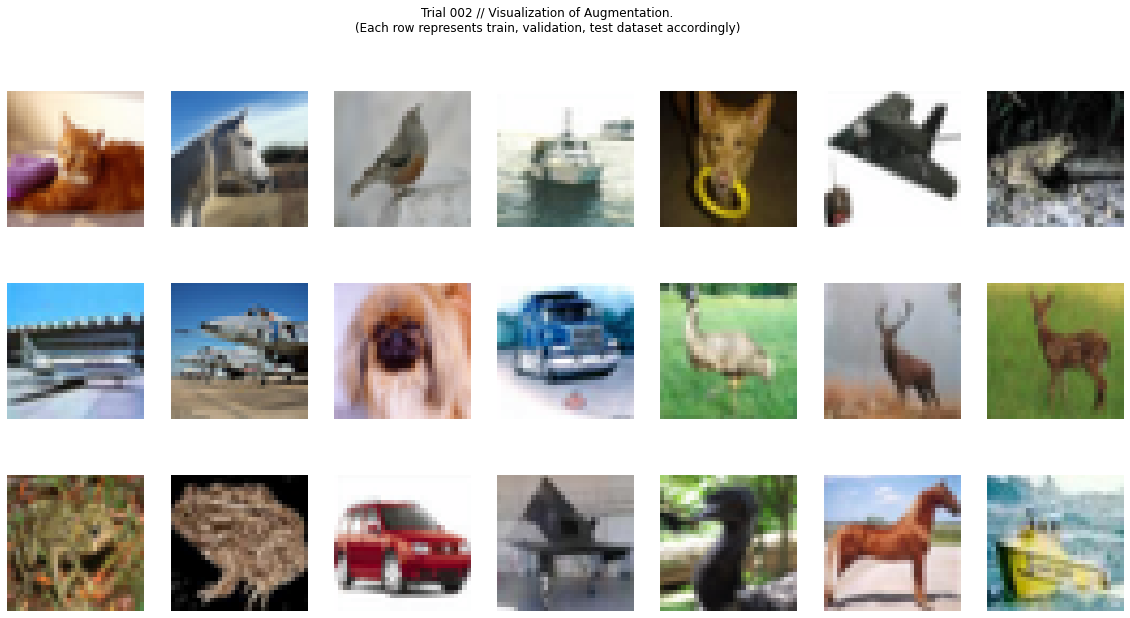

[]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |     34,760 | InvertedResid

Train: [001] Loss: 1.920, Acc: 28.90% F1(macro): 0.28: 100%|██████████| 156/156 [00:13<00:00, 11.40it/s]
 Val:       Loss: 1.670, Acc: 40.21% F1(macro): 0.39: 100%|██████████| 40/40 [00:01<00:00, 25.17it/s]


Model saved. Current best test f1: 0.389


Train: [002] Loss: 1.475, Acc: 46.36% F1(macro): 0.46: 100%|██████████| 156/156 [00:13<00:00, 11.40it/s]
 Val:       Loss: 1.421, Acc: 47.89% F1(macro): 0.48: 100%|██████████| 40/40 [00:01<00:00, 25.70it/s]


Model saved. Current best test f1: 0.476


Train: [003] Loss: 1.314, Acc: 52.69% F1(macro): 0.52: 100%|██████████| 156/156 [00:13<00:00, 11.32it/s]
 Val:       Loss: 1.354, Acc: 51.11% F1(macro): 0.51: 100%|██████████| 40/40 [00:01<00:00, 24.13it/s]


Model saved. Current best test f1: 0.510


Train: [004] Loss: 1.200, Acc: 56.81% F1(macro): 0.57: 100%|██████████| 156/156 [00:13<00:00, 11.36it/s]
 Val:       Loss: 1.292, Acc: 53.74% F1(macro): 0.53: 100%|██████████| 40/40 [00:01<00:00, 25.18it/s]


Model saved. Current best test f1: 0.534


Train: [005] Loss: 1.110, Acc: 60.40% F1(macro): 0.60: 100%|██████████| 156/156 [00:13<00:00, 11.45it/s]
 Val:       Loss: 1.253, Acc: 55.59% F1(macro): 0.55: 100%|██████████| 40/40 [00:01<00:00, 25.27it/s]


Model saved. Current best test f1: 0.554


Train: [006] Loss: 1.029, Acc: 63.28% F1(macro): 0.63: 100%|██████████| 156/156 [00:13<00:00, 11.44it/s]
 Val:       Loss: 1.256, Acc: 56.09% F1(macro): 0.56: 100%|██████████| 40/40 [00:01<00:00, 24.65it/s]


Model saved. Current best test f1: 0.560


Train: [007] Loss: 0.971, Acc: 65.37% F1(macro): 0.65: 100%|██████████| 156/156 [00:13<00:00, 11.32it/s]
 Val:       Loss: 1.233, Acc: 57.19% F1(macro): 0.57: 100%|██████████| 40/40 [00:01<00:00, 25.07it/s]


Model saved. Current best test f1: 0.569


Train: [008] Loss: 0.906, Acc: 67.86% F1(macro): 0.68: 100%|██████████| 156/156 [00:13<00:00, 11.35it/s]
 Val:       Loss: 1.247, Acc: 57.53% F1(macro): 0.57: 100%|██████████| 40/40 [00:01<00:00, 25.56it/s]


Model saved. Current best test f1: 0.574


Train: [009] Loss: 0.867, Acc: 69.06% F1(macro): 0.69: 100%|██████████| 156/156 [00:13<00:00, 11.27it/s]
 Val:       Loss: 1.245, Acc: 58.20% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 25.74it/s]


Model saved. Current best test f1: 0.581


Train: [010] Loss: 0.817, Acc: 70.94% F1(macro): 0.71: 100%|██████████| 156/156 [00:13<00:00, 11.38it/s]
 Val:       Loss: 1.259, Acc: 58.27% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 24.88it/s]


Model saved. Current best test f1: 0.582
TEST DATASET


 Val:       Loss: 1.227, Acc: 58.58% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 26.67it/s]
[I 2021-05-22 20:31:46,852] Trial 2 finished with value: 0.5837755357879962 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': False, 'aug_random_flip': False}. Best is trial 1 with value: 0.6009577855552984.


Files already downloaded and verified
Files already downloaded and verified


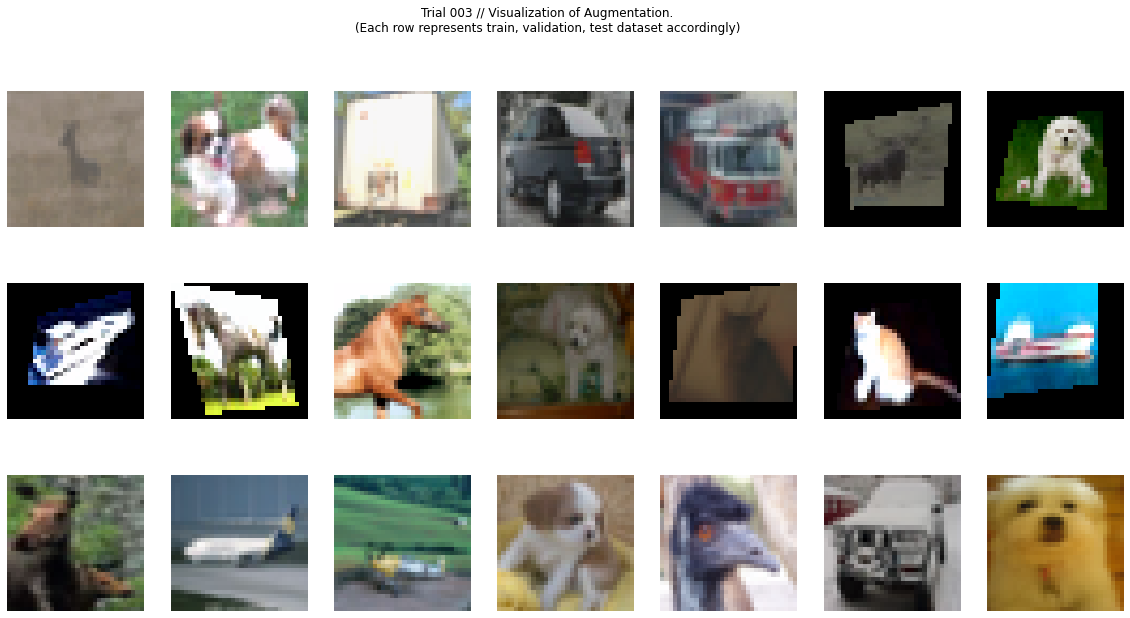

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomPerspective(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,

Train: [001] Loss: 2.170, Acc: 18.48% F1(macro): 0.18: 100%|██████████| 156/156 [00:14<00:00, 10.80it/s]
 Val:       Loss: 2.064, Acc: 25.16% F1(macro): 0.23: 100%|██████████| 40/40 [00:02<00:00, 15.33it/s]


Model saved. Current best test f1: 0.232


Train: [002] Loss: 1.866, Acc: 31.25% F1(macro): 0.30: 100%|██████████| 156/156 [00:14<00:00, 10.87it/s]
 Val:       Loss: 1.842, Acc: 33.57% F1(macro): 0.32: 100%|██████████| 40/40 [00:02<00:00, 15.21it/s]


Model saved. Current best test f1: 0.323


Train: [003] Loss: 1.726, Acc: 36.77% F1(macro): 0.36: 100%|██████████| 156/156 [00:14<00:00, 10.85it/s]
 Val:       Loss: 1.654, Acc: 38.73% F1(macro): 0.37: 100%|██████████| 40/40 [00:02<00:00, 14.75it/s]


Model saved. Current best test f1: 0.373


Train: [004] Loss: 1.635, Acc: 40.33% F1(macro): 0.40: 100%|██████████| 156/156 [00:14<00:00, 10.71it/s]
 Val:       Loss: 1.609, Acc: 41.09% F1(macro): 0.41: 100%|██████████| 40/40 [00:02<00:00, 14.80it/s]


Model saved. Current best test f1: 0.407


Train: [005] Loss: 1.564, Acc: 42.87% F1(macro): 0.43: 100%|██████████| 156/156 [00:14<00:00, 10.83it/s]
 Val:       Loss: 1.555, Acc: 42.60% F1(macro): 0.42: 100%|██████████| 40/40 [00:02<00:00, 14.62it/s]


Model saved. Current best test f1: 0.419


Train: [006] Loss: 1.516, Acc: 44.95% F1(macro): 0.45: 100%|██████████| 156/156 [00:14<00:00, 10.83it/s]
 Val:       Loss: 1.485, Acc: 46.05% F1(macro): 0.46: 100%|██████████| 40/40 [00:02<00:00, 15.08it/s]


Model saved. Current best test f1: 0.458


Train: [007] Loss: 1.467, Acc: 46.74% F1(macro): 0.46: 100%|██████████| 156/156 [00:14<00:00, 10.84it/s]
 Val:       Loss: 1.522, Acc: 44.99% F1(macro): 0.44: 100%|██████████| 40/40 [00:02<00:00, 15.62it/s]
Train: [008] Loss: 1.441, Acc: 48.03% F1(macro): 0.48: 100%|██████████| 156/156 [00:14<00:00, 10.76it/s]
 Val:       Loss: 1.445, Acc: 48.18% F1(macro): 0.47: 100%|██████████| 40/40 [00:02<00:00, 15.15it/s]


Model saved. Current best test f1: 0.474


Train: [009] Loss: 1.404, Acc: 49.58% F1(macro): 0.49: 100%|██████████| 156/156 [00:14<00:00, 10.94it/s]
 Val:       Loss: 1.398, Acc: 50.17% F1(macro): 0.50: 100%|██████████| 40/40 [00:02<00:00, 14.90it/s]


Model saved. Current best test f1: 0.498


Train: [010] Loss: 1.352, Acc: 51.51% F1(macro): 0.51:  91%|█████████ | 142/156 [00:12<00:01,  9.45it/s]

In [ ]:
study = optuna.create_study(direction="maximize", study_name="autoaug", load_if_exists=True)
study.optimize(objective, n_trials=100)